/Users/jaekunpark/Dataset
88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기 (25000, 100)
레이블 텐서의 크기 (25000,)
400000개의 단어 벡터를 찾았습니다
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 1s 139us/sample -

10000/10000 [==============================] - 1s 95us/sample - loss: 5.1759e-04 - binary_accuracy: 0.9999 - val_loss: 4.5777 - val_binary_accuracy: 0.6818
Epoch 94/100
10000/10000 [==============================] - 1s 100us/sample - loss: 5.7907e-09 - binary_accuracy: 1.0000 - val_loss: 4.6818 - val_binary_accuracy: 0.6800
Epoch 95/100
10000/10000 [==============================] - 1s 96us/sample - loss: 3.3186e-09 - binary_accuracy: 1.0000 - val_loss: 4.7279 - val_binary_accuracy: 0.6817
Epoch 96/100
10000/10000 [==============================] - 1s 101us/sample - loss: 2.5383e-09 - binary_accuracy: 1.0000 - val_loss: 4.7662 - val_binary_accuracy: 0.6835
Epoch 97/100
10000/10000 [==============================] - 1s 96us/sample - loss: 2.1869e-09 - binary_accuracy: 1.0000 - val_loss: 4.7818 - val_binary_accuracy: 0.6836
Epoch 98/100
10000/10000 [==============================] - 1s 105us/sample - loss: 2.0309e-09 - binary_accuracy: 1.0000 - val_loss: 4.7936 - val_binary_accuracy: 0.6

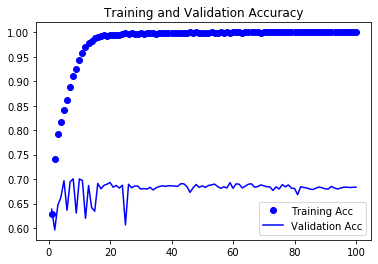

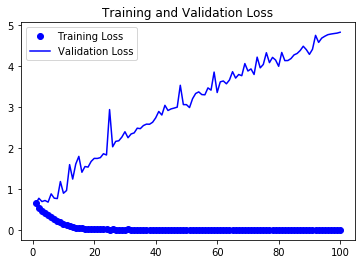

CPU times: user 6min 4s, sys: 59.2 s, total: 7min 4s
Wall time: 1min 56s


In [17]:
%%time
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

currentPath = os.getcwd()
print(currentPath)
os.chdir('/Users/jaekunpark/Dataset')

# IMDB 원본 데이터 전처리
imdb_dir = '/Users/jaekunpark/Dataset/IMDB/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = "utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
# IMDB 원본 데이터의 텍스트를 토큰화

maxlen = 100 # 100개 단어 이후는 버린다.
training_samples = 10000 # 훈련 샘플 200개
validation_samples = 10000 # 검증 샘플 10000개
max_words = 10000 # 빈도 높은 단어 10000개만 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)

print('데이터 텐서의 크기', data.shape)
print('레이블 텐서의 크기', labels.shape)

indices = np.arange(data.shape[0]) # 데이터를 훈련과 검증세트로 분할. 샘플이 순서대로 있으므로 먼저 데이터를 섞는다.
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# GloVe 단어 임베딩 파일 파싱

    #압축 해제한 파일(.txt 파일)을 파싱하여 단어(즉 문자열)와 이에 상응하는 벡터 표현(즉 숫자 벡터)을 매핑하는 인덱스를 만든다.
glove_dir = '/Users/jaekunpark/Dataset/IMDB/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다' %len(embeddings_index))

# GloVe 단어 임베딩 행렬 준비

    # 임베딩 층에 주입할 수 있도록 임베딩 행렬을 만든다. 행렬 크기는 (max_words, embedding_dim)
    # 이 행렬의 i번째 원소는 (토큰화로 만든) 단어 인덱스이 i번쨰 단어에 상응하는 embedding_dim차원 벡터
    # 인덱스 0은 어떤 단어나 토큰도 아닐 경우를 나타낸다.

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # 임베딩 인덱스에 없는 단어는 모두 0이 된다.
            
# 모델 정의

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

# Pretrained Word Embedding 을 'Embedding'층에 load

    # Embedding층은 하나의 가중치 행렬을 가진다. 이 행렬은 2D 부동 소수 행렬이고 각 i번째 원소는 i번째 인덱스에 상응하는 단어 벡터.
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# 모델 훈련 & 평가
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

# 결과 그래프
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()